# Explore here

In [1]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/raw/sales.csv')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df = df.set_index("date")
df.index = pd.to_datetime(df.index)
df.index = df.index.normalize()
df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


In [2]:
df.index

DatetimeIndex(['2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06',
               '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10',
               '2022-09-11', '2022-09-12',
               ...
               '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
               '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
               '2023-09-02', '2023-09-03'],
              dtype='datetime64[ns]', name='date', length=366, freq='D')

Here I'll tranform my data set and use the date as my index:

In [3]:
ts = df['sales']
ts.head()

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Freq: D, Name: sales, dtype: float64

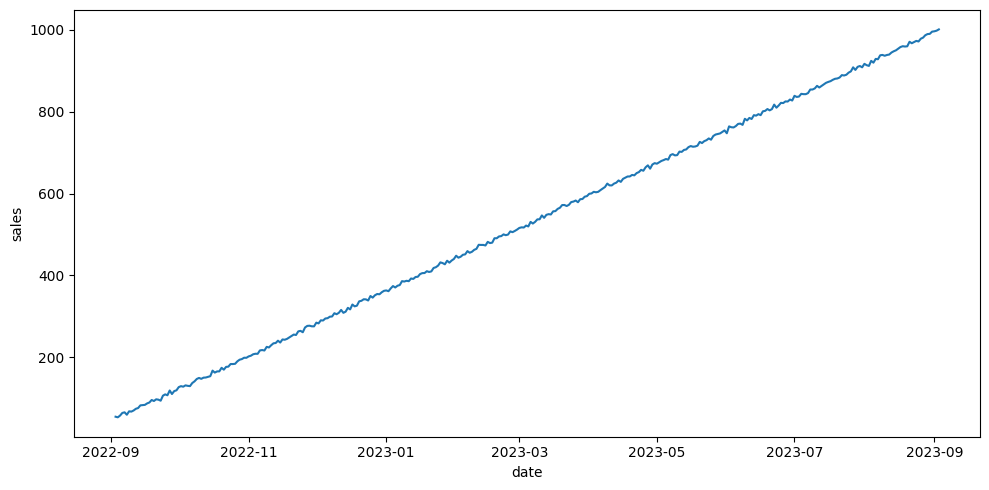

In [4]:
fig, axis = plt.subplots(figsize = (10,5))

sns.lineplot(data = ts)
plt.tight_layout()
plt.show()

We can see that the time here is described in days between the range 0 to 365, so representing a whole year

There's a clear positive trend here. Let's start analysing this data to be sure what we're looking at:

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period = 7)

### Trend Analysis

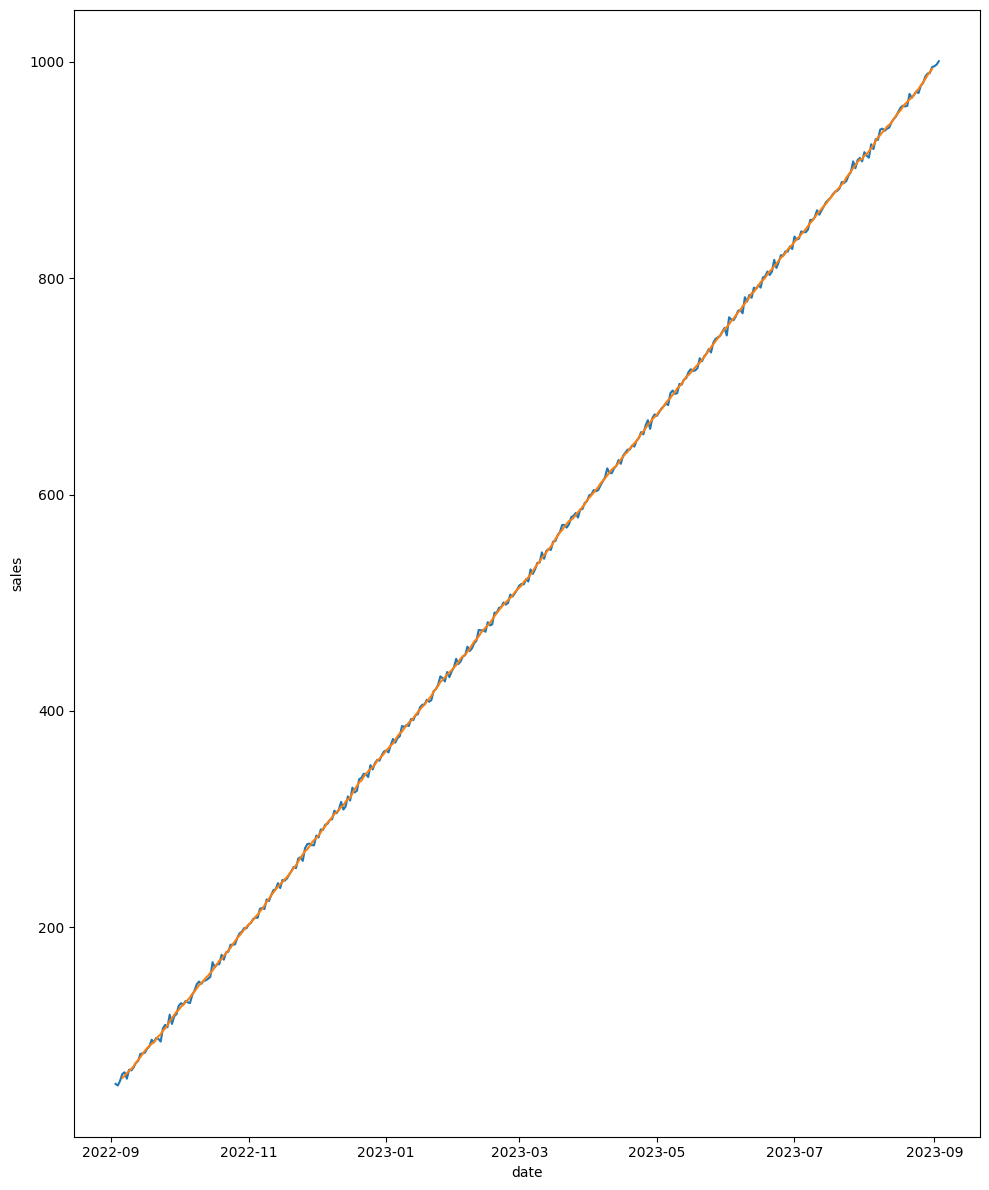

In [6]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize= (10,12))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()
plt.show()

As we can see, the line of the trend follows up with our time series. This confirms a clear positive trend over the year

### Seasonality

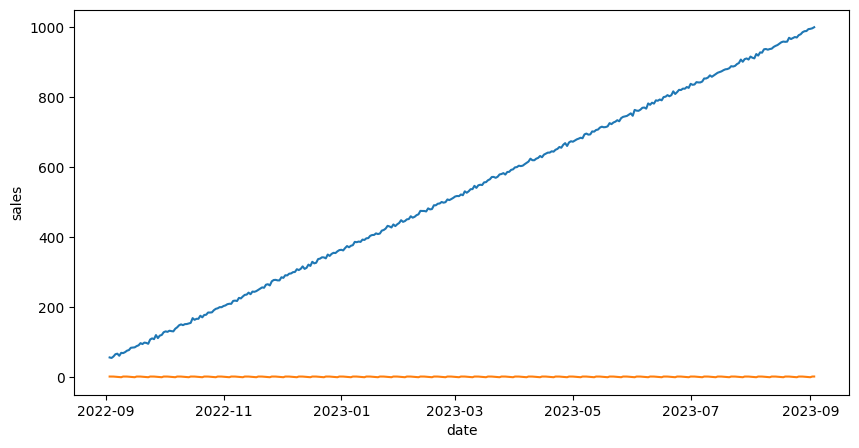

In [7]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize= (10,5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.show()

We can't really know if there is a seasonality because of the short time frame. For only one year it can't really reveal a seasonal pattern that normally repeats every other year, so we'd need a second year at least.

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

The null hypothesis here is that the time series is stationary. As we can observe, the p-value is greater than 0.05, so we reject this hypothesis confirming that it is indeed non-stationary.

In this case, we have a time series that changes over time, making it difficult to train with ARIMA model. Hence, the time series will be transformed into stationary for further analysis

### Variability

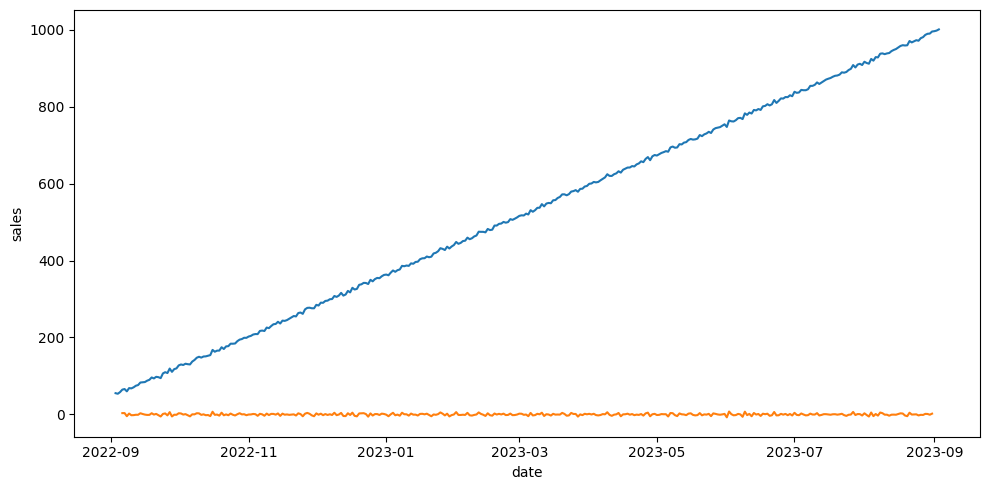

In [9]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)
plt.tight_layout()

plt.show()

From this plot, I can see that there is a low variability, meaning more consistency in the data

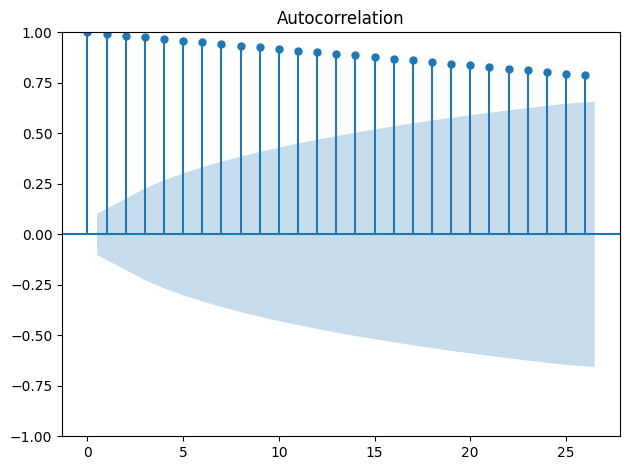

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

As we can see, the autocorrelation coefficient decays to zero quickly. This suggests that the time series are not correlated with each other. There's not really a inherent patter, which makes the time series unpredictable.

In [11]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

As we can see, the p-value is now less than 0.05 so it's stationary and we can use it for our model

### ARIMA model

### Initialize and train the model

In [12]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = False, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1854.775, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2205.881, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2208.143, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1862.229, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1843.049, Time=0.67 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1843.587, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1841.533, Time=0.41 sec
 A

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Mon, 01 Apr 2024   AIC                           1839.553
Time:                        19:46:57   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We'll train the model with this indicated hyperparameters

In [14]:
model.fit(ts_stationary)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

#### Predicting 

In [15]:
forecast = model.predict(20)
forecast

2023-09-04    1.675366
2023-09-05    2.673520
2023-09-06    2.591621
2023-09-07    2.598341
2023-09-08    2.597789
2023-09-09    2.597834
2023-09-10    2.597831
2023-09-11    2.597831
2023-09-12    2.597831
2023-09-13    2.597831
2023-09-14    2.597831
2023-09-15    2.597831
2023-09-16    2.597831
2023-09-17    2.597831
2023-09-18    2.597831
2023-09-19    2.597831
2023-09-20    2.597831
2023-09-21    2.597831
2023-09-22    2.597831
2023-09-23    2.597831
Freq: D, dtype: float64

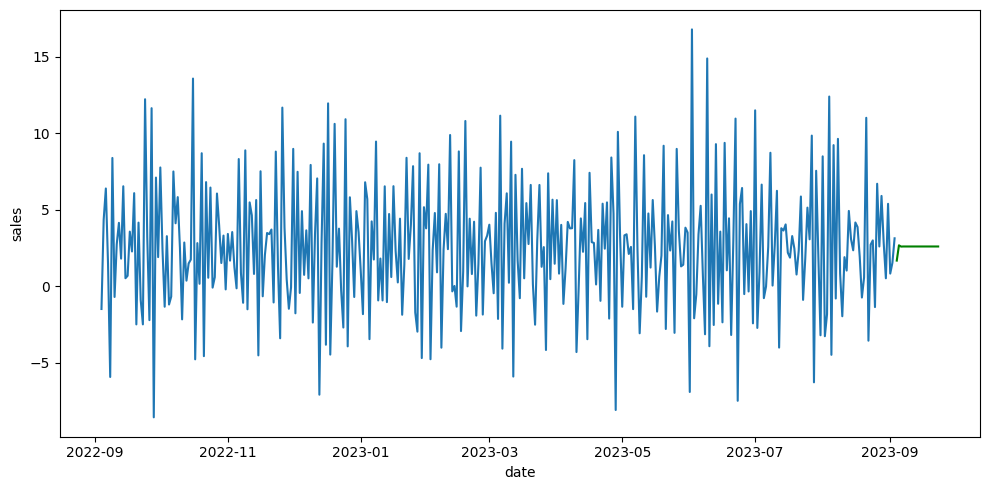

In [16]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [ ]:
from pickle import dump 
dump(model, open("../models/arima_1_0_1.sav", "wb"))